In [2]:
import numpy as np
import matplotlib.pyplot as plt

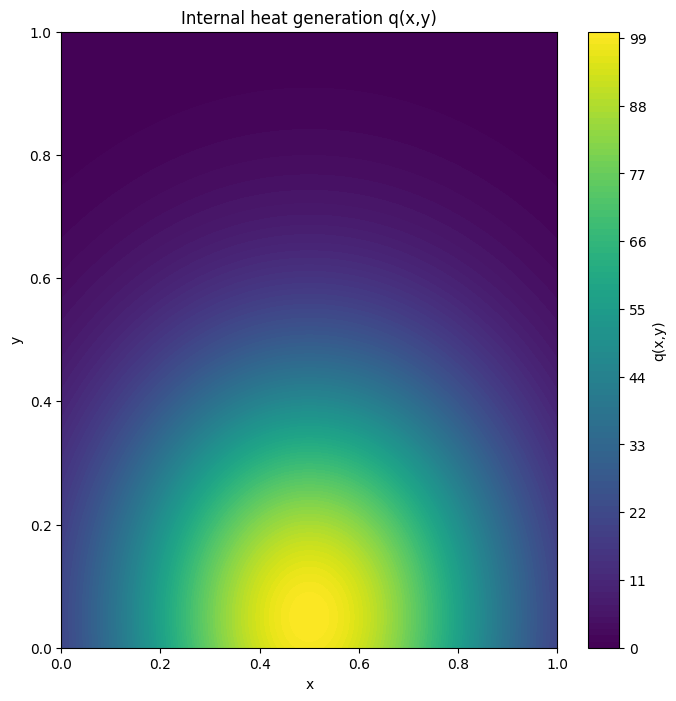

In [3]:
Lx, Ly= 1.0, 1.0
nx, ny = 100,100
x=np.linspace(0,Lx,nx)
y=np.linspace(0,Ly,ny)
X,Y= np.meshgrid(x,y)

Q0=100.0
sigma=0.08
q=Q0*np.exp(-((X-0.5)**2 + (Y-0.05)**2)/(sigma*2))

plt.figure(figsize=(8,8))
plt.contourf(X, Y, q, 100)
plt.colorbar(label='q(x,y)')
plt.title('Internal heat generation q(x,y)')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

In [4]:
def sample_interior(n):
    xs = np.random.rand(n,1) * Lx
    ys = np.random.rand(n,1) * Ly
    return np.hstack([xs, ys])

def sample_boundary(n_per_edge):
    xs = np.linspace(0, Lx, n_per_edge)
    ys = np.linspace(0, Ly, n_per_edge)
    bottom = np.vstack([xs, np.zeros_like(xs)]).T
    top = np.vstack([xs, Ly*np.ones_like(xs)]).T
    left = np.vstack([np.zeros_like(ys), ys]).T
    right = np.vstack([Lx*np.ones_like(ys), ys]).T
    bpoints = np.vstack([bottom, top, left, right])
    return bpoints

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#defining the NEURAL NETWORK ARCHITECTURE
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        z = x
        for i,layer in enumerate(self.layers[:-1]):
            z = layer(z)
            z = torch.tanh(z)
        z = self.layers[-1](z)
        return z

In [7]:
def pde_residual(model, xyt, q_func, k=1.0):
    T = model(xyt)
    grads = torch.autograd.grad(T, xyt, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_x = grads[:,0:1]
    T_y = grads[:,1:2]
    T_xx = torch.autograd.grad(T_x, xyt, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:,0:1]
    T_yy = torch.autograd.grad(T_y, xyt, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:,1:2]
    lap = T_xx + T_yy
    q_val = q_func(xyt)
    residual = lap + q_val / k
    return residual

In [8]:
def q_func_torch(xyt):
    x = xyt[:,0:1]; y = xyt[:,1:2]
    Q0 = 100.0; sigma = 0.08
    qv = Q0 * torch.exp(-((x-0.5)**2 + (y-0.5)**2)/(sigma**2))
    return qv

In [9]:
def loss_function(model, interior_xy, boundary_xy, q_func, k=1.0):
    interior_xy = interior_xy.clone().detach().requires_grad_(True)
    pred_res = pde_residual(model, interior_xy, q_func, k)
    loss_pde = F.mse_loss(pred_res, torch.zeros_like(pred_res))
    Tb = model(boundary_xy)
    loss_bc = F.mse_loss(Tb, torch.zeros_like(Tb))
    return loss_pde + 100*loss_bc, loss_pde.item(), loss_bc.item()

In [13]:
model = PINN([2, 50, 50, 50, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

n_iter = 10000
N_interior = 2000
N_b = 200

for it in range(1, n_iter+1):
    model.train()
    interior = torch.tensor(sample_interior(N_interior), dtype=torch.float32, device=device).requires_grad_(True)
    boundary = torch.tensor(sample_boundary(int(N_b/4)), dtype=torch.float32, device=device)  # total N_b points
    optimizer.zero_grad()
    loss_total, loss_pde, loss_bc = loss_function(model, interior, boundary, q_func_torch, k=1.0)
    loss_total.backward()
    optimizer.step()
    scheduler.step()
    if it % 500 == 0:
        print(f"Iter {it}, total {loss_total.item():.4e}, pde {loss_pde:.4e}, bc {loss_bc:.4e}")

Iter 500, total 4.3370e-01, pde 3.4854e-01, bc 8.5165e-04
Iter 1000, total 1.3891e-01, pde 9.4477e-02, bc 4.4429e-04
Iter 1500, total 1.0558e-01, pde 7.2660e-02, bc 3.2917e-04
Iter 2000, total 7.4562e-02, pde 5.1681e-02, bc 2.2882e-04
Iter 2500, total 6.5506e-02, pde 4.6875e-02, bc 1.8630e-04
Iter 3000, total 5.8150e-02, pde 4.2791e-02, bc 1.5358e-04
Iter 3500, total 4.1675e-02, pde 3.1079e-02, bc 1.0595e-04
Iter 4000, total 3.9970e-02, pde 3.1785e-02, bc 8.1851e-05
Iter 4500, total 3.3788e-02, pde 2.7691e-02, bc 6.0971e-05
Iter 5000, total 3.0724e-02, pde 2.5461e-02, bc 5.2638e-05
Iter 5500, total 2.9532e-02, pde 2.5180e-02, bc 4.3526e-05
Iter 6000, total 2.5121e-02, pde 2.1608e-02, bc 3.5128e-05
Iter 6500, total 2.2893e-02, pde 1.9838e-02, bc 3.0546e-05
Iter 7000, total 2.2981e-02, pde 2.0286e-02, bc 2.6949e-05
Iter 7500, total 2.2056e-02, pde 1.9636e-02, bc 2.4198e-05
Iter 8000, total 2.1025e-02, pde 1.8932e-02, bc 2.0929e-05
Iter 8500, total 1.9623e-02, pde 1.7674e-02, bc 1.9491e-0

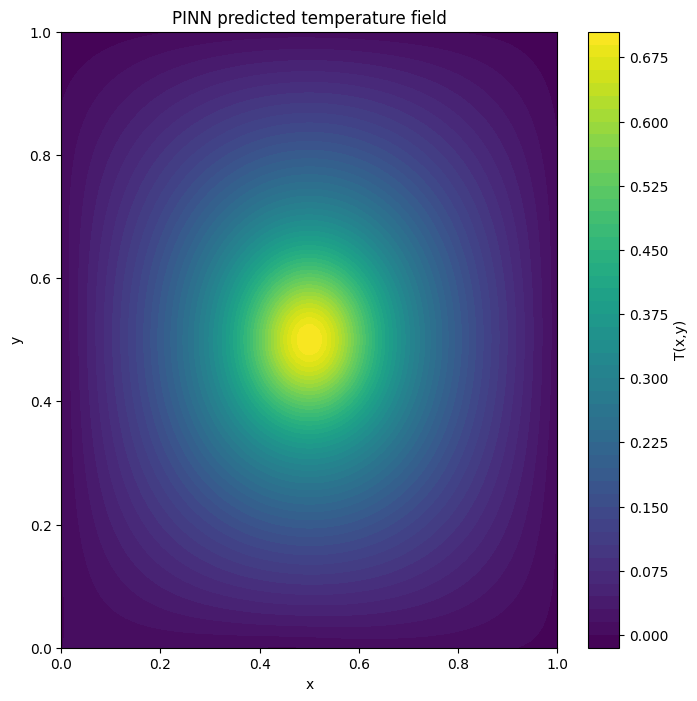

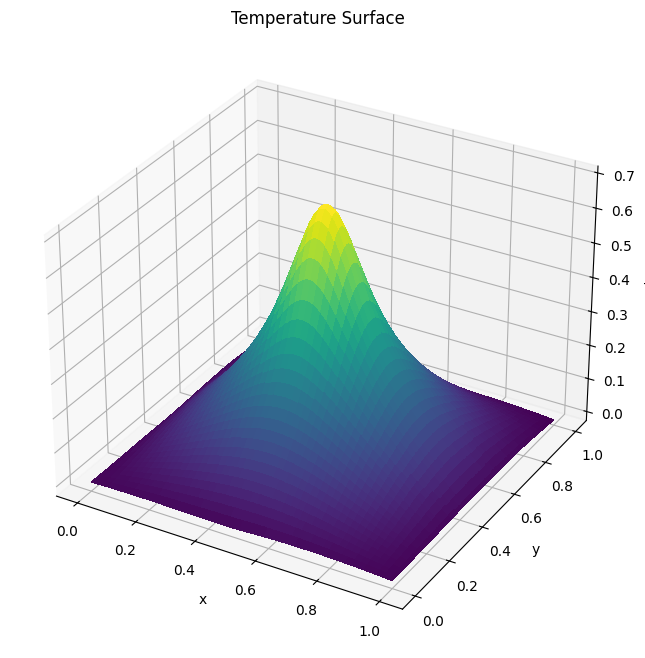

In [15]:
xx = np.linspace(0, Lx, nx)
yy = np.linspace(0, Ly, ny)
XX, YY = np.meshgrid(xx, yy)
grid = np.vstack([XX.ravel(), YY.ravel()]).T
grid_t = torch.tensor(grid, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    T_pred = model(grid_t).cpu().numpy().reshape((ny, nx))

# plot 2D heatmap
plt.figure(figsize=(8,8))
plt.contourf(XX, YY, T_pred, 60)
plt.colorbar(label='T(x,y)')
plt.title('PINN predicted temperature field')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

# 3D surface (matplotlib)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, T_pred, cmap='viridis', linewidth=0, antialiased=False)
ax.set_title('Temperature Surface')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('T')
plt.show()


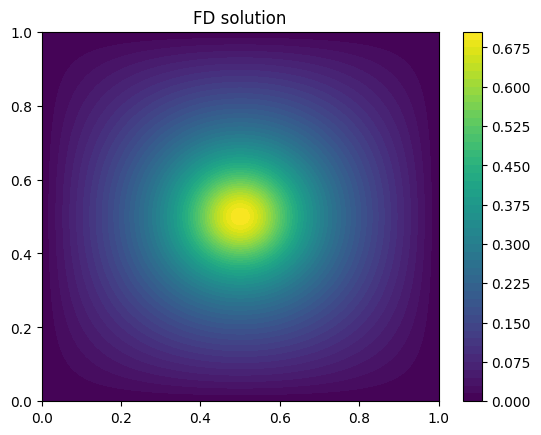

In [28]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def solve_fd_poisson(nx, ny, q_fn, k=1.0):
    dx = Lx/(nx-1); dy = Ly/(ny-1)
    N = nx*ny
    rows = []; cols = []; vals = []; b = np.zeros(N)
    def idx(i,j): return i + j*nx
    for j in range(ny):
        for i in range(nx):
            p = idx(i,j)
            if i==0 or i==nx-1 or j==0 or j==ny-1:
                # Dirichlet BC: T=0
                rows.append(p); cols.append(p); vals.append(1.0)
                b[p] = 0.0
            else:
                # interior: -4T_i + T_left + T_right + T_up + T_down = -dx^2 * q/k
                rows.extend([p,p,p,p,p])
                cols.extend([p, idx(i-1,j), idx(i+1,j), idx(i,j-1), idx(i,j+1)])
                vals.extend([-4.0, 1.0, 1.0, 1.0, 1.0])
                x_ = i*dx; y_ = j*dy
                b[p] = - (dx**2) * q_fn(x_, y_) / k
    A = sp.csr_matrix((vals, (rows, cols)), shape=(N,N))
    sol = spla.spsolve(A, b)
    return sol.reshape((ny,nx))

def q_fn_np(x,y):
    return Q0 * np.exp(-((x-0.5)**2+(y-0.5)**2)/(sigma**2))

T_fd = solve_fd_poisson(nx, ny, q_fn_np, k=1.0)
plt.contourf(XX, YY, T_fd, 60); plt.title('FD solution'); plt.colorbar()
plt.show()


In [18]:
err = np.linalg.norm(T_pred - T_fd)/np.linalg.norm(T_fd)
print("Relative L2 error:", err)


Relative L2 error: 0.011859823211724713


In [19]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=T_pred, x=XX, y=YY)])
fig.update_layout(title='PINN Temperature Surface', autosize=True,
                  scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='T'))
fig.show()


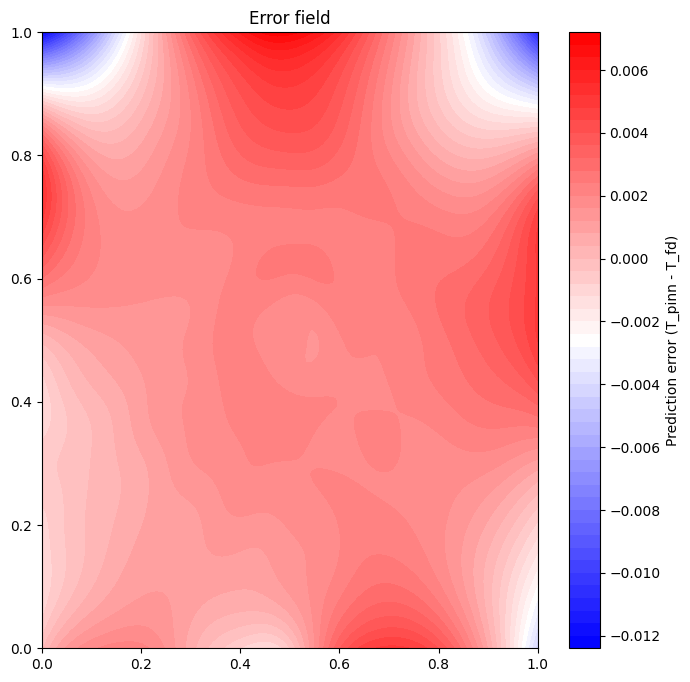

In [21]:
plt.figure(figsize=(8,8))
plt.contourf(XX, YY, T_pred - T_fd, 60, cmap='bwr')
plt.colorbar(label='Prediction error (T_pinn - T_fd)')
plt.title('Error field')
plt.show()


In [22]:
# Hyperparameters
layers = [2, 60, 60, 60, 60, 1]    # MLP architecture
lr = 1e-3                          # learning rate
num_iters = 12000                  # training iterations
N_interior = 4000                  # collocation samples
N_boundary = 400                   # boundary samples
bc_weight = 100.0                  # weight for boundary loss
k_value = 1.0                      # thermal conductivity

model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)

loss_history, loss_pde_hist, loss_bc_hist = [], [], []


In [23]:
for it in range(1, num_iters+1):
    model.train()
    interior = torch.tensor(sample_interior(N_interior), dtype=torch.float32, device=device).requires_grad_(True)
    boundary = torch.tensor(sample_boundary(int(N_boundary/4)), dtype=torch.float32, device=device)
    optimizer.zero_grad()

    loss_total, loss_pde, loss_bc = loss_function(model, interior, boundary, q_func_torch, k=k_value)
    loss_total.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss_total.item())
    loss_pde_hist.append(loss_pde)
    loss_bc_hist.append(loss_bc)

    if it % 500 == 0:
        print(f"Iter {it:05d}: Total={loss_total.item():.3e}, PDE={loss_pde:.3e}, BC={loss_bc:.3e}")

lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=1000, tolerance_grad=1e-8, tolerance_change=1e-9, history_size=100)

def closure():
    lbfgs.zero_grad()
    interior = torch.tensor(sample_interior(N_interior), dtype=torch.float32, device=device).requires_grad_(True)
    boundary = torch.tensor(sample_boundary(int(N_boundary/4)), dtype=torch.float32, device=device)
    loss_total, _, _ = loss_function(model, interior, boundary, q_func_torch, k=k_value)
    loss_total.backward()
    return loss_total

print("\n--- Starting LBFGS fine-tuning ---")
lbfgs.step(closure)
print("--- LBFGS finished ---")


Iter 00500: Total=1.540e-01, PDE=8.055e-02, BC=7.349e-04
Iter 01000: Total=1.008e-01, PDE=5.155e-02, BC=4.921e-04
Iter 01500: Total=1.357e-01, PDE=8.751e-02, BC=4.816e-04
Iter 02000: Total=7.177e-02, PDE=4.086e-02, BC=3.091e-04
Iter 02500: Total=6.273e-02, PDE=3.611e-02, BC=2.662e-04
Iter 03000: Total=7.008e-02, PDE=4.532e-02, BC=2.476e-04
Iter 03500: Total=4.677e-02, PDE=2.733e-02, BC=1.944e-04
Iter 04000: Total=4.453e-02, PDE=2.714e-02, BC=1.739e-04
Iter 04500: Total=3.482e-02, PDE=2.223e-02, BC=1.258e-04
Iter 05000: Total=2.866e-02, PDE=1.927e-02, BC=9.382e-05
Iter 05500: Total=3.093e-02, PDE=2.303e-02, BC=7.901e-05
Iter 06000: Total=3.049e-02, PDE=2.030e-02, BC=1.018e-04
Iter 06500: Total=1.868e-02, PDE=1.406e-02, BC=4.619e-05
Iter 07000: Total=1.603e-02, PDE=1.223e-02, BC=3.799e-05
Iter 07500: Total=1.703e-02, PDE=1.332e-02, BC=3.707e-05
Iter 08000: Total=1.557e-02, PDE=1.245e-02, BC=3.122e-05
Iter 08500: Total=1.199e-02, PDE=9.470e-03, BC=2.520e-05
Iter 09000: Total=1.170e-02, PD

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)



--- LBFGS finished ---


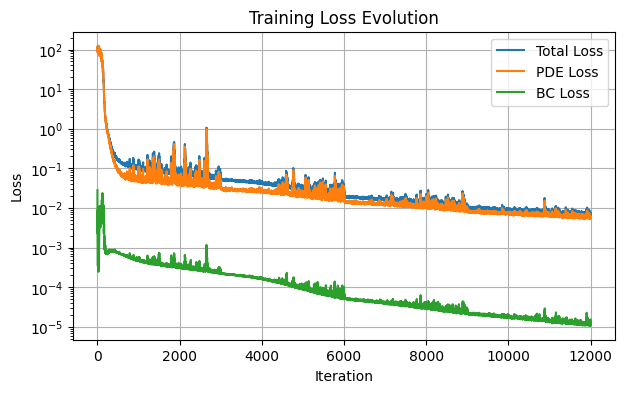

In [24]:
plt.figure(figsize=(7,4))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_pde_hist, label='PDE Loss')
plt.plot(loss_bc_hist, label='BC Loss')
plt.yscale('log')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.title('Training Loss Evolution')
plt.legend(); plt.grid(True)
plt.show()


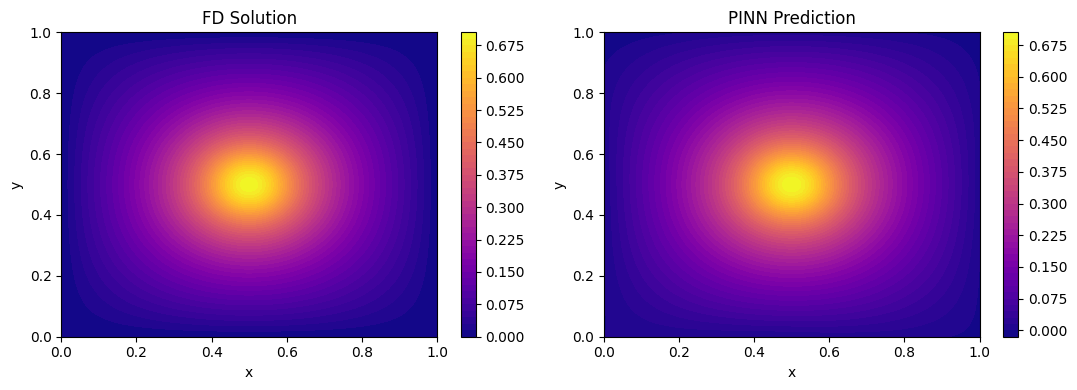

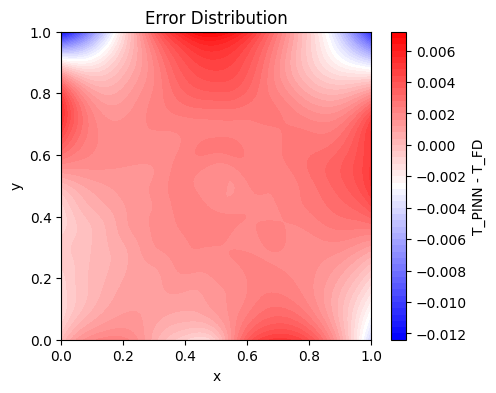

Relative L2 Error = 1.1860e-02


In [25]:
# 2D contour comparison
fig, ax = plt.subplots(1, 2, figsize=(11,4))
cs1 = ax[0].contourf(XX, YY, T_fd, 60, cmap='plasma')
ax[0].set_title('FD Solution')
plt.colorbar(cs1, ax=ax[0])

cs2 = ax[1].contourf(XX, YY, T_pred, 60, cmap='plasma')
ax[1].set_title('PINN Prediction')
plt.colorbar(cs2, ax=ax[1])

for a in ax:
    a.set_xlabel('x'); a.set_ylabel('y')
plt.tight_layout(); plt.show()

err_field = T_pred - T_fd
plt.figure(figsize=(5,4))
plt.contourf(XX, YY, err_field, 50, cmap='bwr')
plt.colorbar(label='T_PINN - T_FD')
plt.title('Error Distribution')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

rel_L2 = np.linalg.norm(err_field)/np.linalg.norm(T_fd)
print(f"Relative L2 Error = {rel_L2:.4e}")


In [26]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=XX, y=YY, z=T_pred, colorscale='Viridis')])
fig.update_layout(
    title='2D Steady Heat Equation PINN',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='Temperature',
        aspectratio=dict(x=1, y=1, z=0.5)
    )
)
fig.show()
fig.write_html("PINN_heat_surface.html")
